The objective of this project is to create a pricing model for s&p500 event contracts using the 200 day moving average indicator (DMAVG200)

Exchange:
https://kalshi.com/

Information on event contracts:
https://www.cmegroup.com/activetrader/event-contracts.html


In [201]:
from fileinput import filename
from hashlib import new
from operator import index
from sqlalchemy import true
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

The SPX_5min.csv file contains all recorded S&P500 prices in five minute intervals from 2007-2022

In [145]:
all_data = pd.read_csv('SPX_5min.csv')
display(all_data)

,DateTime,Open,High,Low,Close
0,2007-09-25 09:30:00,1516.34,1516.34,1509.11,1510.13
1,2007-09-25 09:35:00,1509.42,1509.66,1508.77,1508.77
2,2007-09-25 09:40:00,1508.45,1509.49,1508.17,1508.17
3,2007-09-25 09:45:00,1508.39,1510.27,1508.18,1509.99
4,2007-09-25 09:50:00,1509.96,1510.91,1509.81,1510.11
...,...,...,...,...,...
299190,2022-08-19 15:45:00,4229.15,4230.33,4226.23,4228.86
299191,2022-08-19 15:50:00,4228.88,4233.92,4227.91,4229.38
299192,2022-08-19 15:55:00,4229.55,4231.15,4228.06,4228.37
299193,2022-08-19 16:00:00,4228.16,4228.48,4228.16,4228.48


For this project I am predicting the price distribution on the market open at 9:30 and close at 4:00. This function takes the data from those times and gives the opening and closing prices every day.

In [146]:
def getOpeningClosing(market_data = all_data, open_time = "09:30:00", close_time = '16:00:00'):
    
    open_prices_df = market_data[market_data['DateTime'].str.contains(open_time)]
    open_prices_df['DateOnly'] = open_prices_df.apply(lambda row: row['DateTime'].split()[0], axis=1)

    close_prices_df = market_data[market_data['DateTime'].str.contains(close_time)]
    close_prices_df['DateOnly'] = close_prices_df.apply(lambda row: row['DateTime'].split()[0], axis=1)

    merged_open_close = pd.merge(open_prices_df, close_prices_df, on='DateOnly', how='inner')

    open_close_df = pd.DataFrame({
        'Date': merged_open_close['DateOnly'],
        'Open': merged_open_close[' Open_x'],
        'Close': merged_open_close[' Open_y']
    })
    display(open_close_df)
    return open_close_df
    
    

In [147]:
open_close_data = getOpeningClosing()

/var/folders/hz/0nf1hypj0111z36yf84mzlmm0000gn/T/ipykernel_8317/3101069366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_prices_df['DateOnly'] = open_prices_df.apply(lambda row: row['DateTime'].split()[0], axis=1)
/var/folders/hz/0nf1hypj0111z36yf84mzlmm0000gn/T/ipykernel_8317/3101069366.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices_df['DateOnly'] = close_prices_df.apply(lambda row: row['DateTime'].split()[0], axis=1)


,Date,Open,Close
0,2007-09-25,1516.34,1518.17
1,2007-09-26,1518.62,1525.44
2,2007-09-27,1527.32,1531.55
3,2007-09-28,1531.24,1526.75
4,2007-10-01,1527.29,1546.96
...,...,...,...
3716,2022-08-15,4269.37,4297.24
3717,2022-08-16,4290.46,4305.18
3718,2022-08-17,4280.40,4274.28
3719,2022-08-18,4273.13,4284.51


Now that we have the opening and closing prices we need to calculate the trailing 200 day moving average for every day as well as the percentage change

In [148]:
DMAVGs = []
DMAVG_ratios = []
perc_change = []

for index, row in open_close_data.iterrows():
    if index >= 200:
        trailing_200_day_data = open_close_data['Close'][index-200: index]
        DMAVG200 = trailing_200_day_data.mean()
        DMAVGs.append(DMAVG200)
        DMAVG_ratio = DMAVG200/row['Open']
        DMAVG_ratios.append(DMAVG_ratio)


        perc_change.append(((row['Close']-row['Open'])/row['Open'])*100)


    else:
        perc_change.append(np.nan)
        DMAVGs.append(np.nan)
        DMAVG_ratios.append(np.nan)

open_close_data['DMAVG(200)'] = DMAVGs
open_close_data['DMAVG(200)_Ratio'] = DMAVG_ratios
open_close_data['% Change'] = perc_change

final_data = open_close_data.iloc[200:]
display(final_data)


,Date,Open,Close,DMAVG(200),DMAVG(200)_Ratio,% Change
200,2008-07-16,1214.65,1244.97,1401.50090,1.153831,2.496192
201,2008-07-17,1246.31,1259.24,1400.13490,1.123424,1.037463
202,2008-07-18,1258.22,1260.15,1398.80390,1.111732,0.153391
203,2008-07-21,1261.82,1259.68,1397.44690,1.107485,-0.169596
204,2008-07-22,1257.08,1276.63,1396.11155,1.110599,1.555191
...,...,...,...,...,...,...
3716,2022-08-15,4269.37,4297.24,4329.00155,1.013967,0.652790
3717,2022-08-16,4290.46,4305.18,4327.61710,1.008660,0.343087
3718,2022-08-17,4280.40,4274.28,4326.38460,1.010743,-0.142977
3719,2022-08-18,4273.13,4284.51,4324.77580,1.012086,0.266315


Bellow is a scatter plot showing the impact of the 200DMAVG on price. When the price at or above the 200DMAVG the market is less volatile. When the price is bellow the 200DMAVG the probability of a large price movement up or down increases. As you can see all of the largest moves in the market occured when price was significantly bellow the 200DMAVG. The 200 DMAVG is a good indicator of the variance in the market.

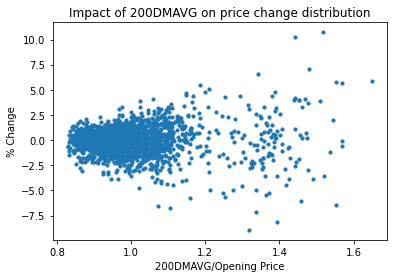

In [150]:
plt.scatter(final_data['DMAVG(200)_Ratio'], final_data['% Change'], s=10)
plt.title('Impact of 200DMAVG on price change distribution')
plt.xlabel('200DMAVG/Opening Price')
plt.ylabel('% Change')

plt.show()

So now that we have we need to make a prediction model for pricing event contracts. We will do this by sampling how the market behaves in similar market conditions and finding the probability of the market moving into that range. We will then apply a confidence 

In [213]:
def priceContract(current_index_price, sample_dmavg_range, contract_range, z=1.96):
    #adjust contract range for % data
    adj_contract_range = {
        'low': 100*(contract_range['low']-current_index_price)/current_index_price,
        'high': 100*(contract_range['high']-current_index_price)/current_index_price
    }

    filtered_data = final_data[(final_data['DMAVG(200)_Ratio'] >= sample_dmavg_range['low']) & (final_data['DMAVG(200)_Ratio'] <= sample_dmavg_range['high'])]
    prob = ((filtered_data['% Change'] >= adj_contract_range['low']) & (filtered_data['% Change'] <= adj_contract_range['high'])).sum()/len(filtered_data)


    n = len(filtered_data)
    confidence_interval = confidenceInterval = {
        'low': prob - z*math.sqrt((prob*(1-prob))/n), 
        'high': prob + z*math.sqrt((prob*(1-prob))/n),
        'z': z
    }

    display(confidence_interval)



    

This function prices the contract in range 4150-4199.99 on May 1st 2023 https://kalshi.com/events/INXD-23MAY01/markets/INXD-23MAY01-B4175/. The function will return 95% confidence interval for the price of the contract. Our function places the fair value of the contract between .667 and .702. This is consistent with the contracts price as of 9:30 ET of 68. 

In [214]:
priceContract(4167.87, {'low': .8, 'high': 1}, {'low': 4150, 'high':4199.99})

{'low': 0.6675238843134558, 'high': 0.7023191240837695, 'z': 1.96}